In [1]:
%matplotlib inline
from collections import Counter, OrderedDict, defaultdict
import copy
import glob
import itertools
from itertools import izip
import itertools
import os
import subprocess
import tempfile
import random

from IPython.core.display import HTML, Image
import itertools
import pandas as pd
from matplotlib import gridspec
from matplotlib import pyplot
import matplotlib.patches as mpatches

import matplotlib as mpl
from matplotlib_venn import venn2, venn3
import numpy as np
import scipy
import seaborn as sns

from clipper.src import CLIP_analysis
from clipper.src import get_genomic_regions
import flotilla
from gscripts import GO
from gscripts.general import dataviz
from gscripts.general import parsers
from gscripts.general import region_helpers
from gscripts.rnaseq.helpers import counts_to_rpkm

img_dir = "/home/gpratt/Dropbox/mouse_stress/figures"

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
count_file = "/projects/ps-yeolab2/for_anthony/analysis/av_mouse_stress_v3/all_counts.txt"
count_df = pd.read_table(count_file, skiprows=1, index_col=0)
count_df.columns = [os.path.basename(item).split(".")[0] for item in count_df.columns]

rpkm_df = counts_to_rpkm(count_df).T
rpkm_df.columns = [item.split(".")[0] for item in rpkm_df.columns]
flotilla_rpkm_df = rpkm_df.copy()

In [4]:
all_splicing_events = pd.read_csv("/projects/ps-yeolab2/for_anthony/analysis/av_mouse_stress_v3/combined_output/miso_summary_filtered.csv", index_col=[-2, 2])
se_splicing_events = all_splicing_events[all_splicing_events.splice_type == "SE"]
splicing_df = se_splicing_events.groupby(level=["sample_id", "event_name"]).first().miso_posterior_mean.unstack().fillna(.5)

/home/gpratt/anaconda/lib/python2.7/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


In [5]:
metadata = pd.DataFrame(index=splicing_df.index)
metadata['cell_type'] = "Mouse NPCs"
metadata['exp'] = ["_".join(item.split("_")[:-4]) for item in metadata.index]
metadata['stress'] = [True if "stress" in item else False for item in metadata.index]
metadata['phenotype'] = ["_".join(item.split("_")[:-4]) for item in metadata.index]
metadata['rep'] = [item.split("_")[3].lower() for item in metadata.index]
metadata['outlier'] = False
metadata['date'] = ["june" if ((item == "a") or (item == 'b')) else "may" for item in metadata.rep]
metadata.rep[~((metadata.rep == "a") | (metadata.rep == 'b'))] = 'a'

genotypes = ['gt', 'hWT', 'q331k', 'rev', 'wt']
result = []
for item in metadata.index:
    for genotype in genotypes:
        if genotype.lower() in item.lower():
            if genotype == 'wt':
                genotype = 'hWT'
            result.append(genotype)
            break
metadata['genotype'] = result
metadata['sample_id'] = metadata.index 

/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
mn_study_unstressed = flotilla.Study(# The metadata describing phenotype and pooled samples
                       metadata,
                       # A version for this data
                       version='0.1.0',
                       expression_data = flotilla_rpkm_df[(metadata.date == "june") & ~metadata.stress ],
                       # Dataframe of the splicing data
                       splicing_data=splicing_df[(metadata.date == "june") & metadata.stress],
                       expression_thresh = 1,
                       species="mm10"
)

2016-02-17 16:35:07	Initializing Study
2016-02-17 16:35:07	Initializing Predictor configuration manager for Study
2016-02-17 16:35:07	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-02-17 16:35:07	Added ExtraTreesClassifier to default predictors
2016-02-17 16:35:07	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-02-17 16:35:07	Added ExtraTreesRegressor to default predictors
2016-02-17 16:35:07	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-02-17 16:35:07	Added GradientBoostingClassifier to default predictors
2016-02-17 16:35:07	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2016-02-17 16:35:07	Added GradientBoostingRegressor to default predictors
2016-02-17 16:35:07	Loading metadata
2016-02-17 16:35:07	Loading species metadata from ~/f

No phenotype to color mapping was provided, falling back on reasonable defaults.
No phenotype to marker (matplotlib plotting symbol) was provided, so each phenotype will be plotted as a circle in visualizations.
Error loading species mm10 data: HTTP Error 404: Not Found

https://s3-us-west-2.amazonaws.com/flotilla-projects/ercc/ERCC_Controls.txt has not been downloaded before.
2016-02-17 16:35:11	Loading expression data
2016-02-17 16:35:11	Initializing expression
2016-02-17 16:35:11	Done initializing expression
2016-02-17 16:35:13	Loading splicing data
2016-02-17 16:35:13	Initializing splicing
2016-02-17 16:35:13	Done initializing splicing
2016-02-17 16:35:13	Successfully initialized a Study object!


/home/gpratt/anaconda/lib/python2.7/site-packages/flotilla/data_model/metadata.py:188: UserWarning: MetaData.phenotype_series will be deprecated in 0.3.0
  warnings.warn('MetaData.phenotype_series will be deprecated in 0.3.0')
/home/gpratt/anaconda/lib/python2.7/site-packages/flotilla/visualize/decomposition.py:177: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  self.magnitudes.sort(ascending=False)
/home/gpratt/anaconda/lib/python2.7/site-packages/flotilla/visualize/decomposition.py:184: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  x.sort(ascending=True)
/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


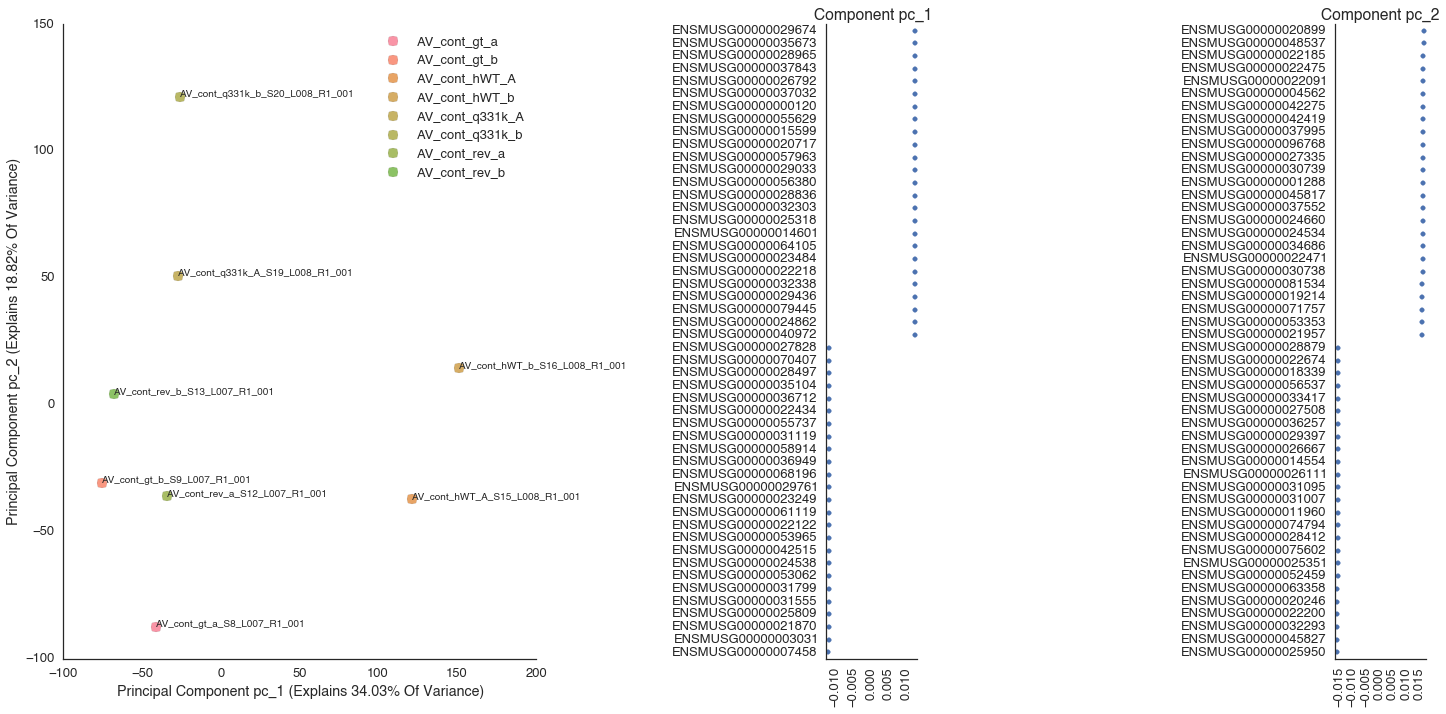

In [7]:
unstressed_protein_coding_pca = mn_study_unstressed.plot_pca(feature_subset="gene_type: protein_coding", 
                             show_vectors=False, 
                             show_point_labels=True,
                             most_variant_features=False)
pyplot.savefig(os.path.join(img_dir, "unstressed_expression_protein_coding_pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "unstressed_expression_protein_coding_pca.svg"))

In [9]:
mm10GO = GO.GO(GOFile="/projects/ps-yeolab/genomes/mm10/mm10_ENSEMBL_TO_GO.txt.gz")

In [10]:
pc2 = unstressed_protein_coding_pca.loadings.ix['pc_2'].sort_values(ascending=False)
large_sets = mm10GO.GO[(mm10GO.GO['nGenes'] > 25) & (mm10GO.GO['nGenes'] < 500)] 

In [15]:
result = {}
in_set = {}
for name, genes in large_sets['Ensembl Gene ID'].iteritems():
    result[name] = pc2.copy()
    in_set[name] = {gene_id: True for gene_id in genes}

result = pd.DataFrame(result)
in_set = pd.DataFrame(in_set)
in_set = in_set.fillna(False)

incomplete_in_set = in_set.T

for gene in result.index.difference(in_set.index):
    incomplete_in_set[gene] = False
    
in_set = incomplete_in_set[result.index].T

#is_set = in_set.reindex(result.index, fill_value=False)

hit_values = result.copy()
miss_values = result.copy()

hit_values[~in_set] = 0
hit_values = np.abs(hit_values)
miss_values[:] = 0
miss_values[~in_set] = 1

In [14]:
enrichment_score = enrichment_score_vectorized(hit_values, miss_values)
largest_enrichment = get_largest_score_vectorized(enrichment_score)

NameError: name 'hit_values' is not defined

In [ ]:
#normalize outside of the call
normalized_hit_values = hit_values / hit_values.sum()
normalized_miss_values = miss_values / miss_values.sum()

results = {}
for x in range(5):
    index = list(hit_values.index)
    np.random.shuffle(index)
    shuffled_hit_values = normalized_hit_values.ix[index]
    shuffled_miss_values = normalized_miss_values.ix[index]

    results[x] = fast_get_largest_score_vectorized(fast_normalized_enrichment_score_vectorized(shuffled_hit_values, shuffled_miss_values))

shuffled_results = pd.DataFrame(results).unstack()

In [13]:
def enrichment_score_vectorized(hit_values, miss_values):
    normalized_hit_values = hit_values / hit_values.sum()
    normalized_miss_values = miss_values / miss_values.sum()

    enrichment_score = normalized_hit_values.cumsum() - normalized_miss_values.cumsum()
    return enrichment_score

def get_largest_score_vectorized(enrichment_score):
    combined_scores = pd.concat({"max_score": enrichment_score.max(), "min_score": enrichment_score.min()}).unstack()
    return combined_scores.apply(lambda x: x.max_score if np.abs(x.max_score) > np.abs(x.min_score) else x.min_score, axis=0)

def normalized_enrichment_score_vectorized(normalized_hit_values, normalized_miss_values):
    enrichment_score = normalized_hit_values.cumsum() - normalized_miss_values.cumsum()
    return enrichment_score

def fast_normalized_enrichment_score_vectorized(normalized_hit_values, normalized_miss_values):
    enrichment_score = normalized_hit_values.as_matrix().cumsum(axis=0) - normalized_miss_values.as_matrix().cumsum(axis=0)
    return enrichment_score

def fast_get_largest_score_vectorized(enrichment_score):
    #Enrichment score is already a matrix
    #I intentionally ignore WHERE the max score is here for speed purposes.  Its not important for the shuffling, only the non-shuffled case
    max_scores = enrichment_score.max(axis=0)
    min_scores = enrichment_score.min(axis=0)

    max_scores[np.abs(max_scores) < np.abs(min_scores)] = min_scores[np.abs(max_scores) < np.abs(min_scores)] 
    return max_scores

In [ ]:
get_largest_score_vectorized(normalized_enrichment_score_vectorized(shuffled_hit_values, shuffled_miss_values))
fast_get_largest_score_vectorized(fast_normalized_enrichment_score_vectorized(shuffled_hit_values, shuffled_miss_values))

In [ ]:
result = {}
in_set = {}
for name, genes in large_sets['Ensembl Gene ID'].iteritems():
    result[name] = pc2.copy()
    in_set[name] = {gene_id: True for gene_id in genes}

result = pd.DataFrame(result)
in_set = pd.DataFrame(in_set)
in_set = in_set.fillna(False)

incomplete_in_set = in_set.T

for gene in result.index.difference(in_set.index):
    incomplete_in_set[gene] = False
    
in_set = incomplete_in_set[result.index].T

#is_set = in_set.reindex(result.index, fill_value=False)

hit_values = result.copy()
miss_values = result.copy()

hit_values[~in_set] = 0
hit_values = np.abs(hit_values)
miss_values[:] = 0
miss_values[~in_set] = 1

#Old GSEA This version is slow as balls

In [2]:
ranked_list = pd.read_table("ranked_gene_list_MALE_versus_FEMALE_1455561427103.xls", index_col=0)
pc2 = ranked_list.SCORE

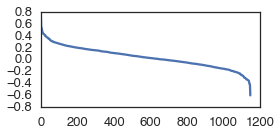

In [8]:
with dataviz.Figure(os.path.join(img_dir, "control_change.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.plot(pc2.SCORE)
    ax.plot

In [7]:
print "".join(list(reversed("CCAAGGCGAACGTGATAACCACTACACTACGGAAAC")))

CAAAGGCATCACATCACCAATAGTGCAAGCGGAACC


In [19]:
gene_sets = {}
with open("h.all.v5.1.symbols.gmt") as fn:
    for line in fn:
        line =line.split()
        gene_set = line[0]
        loc = line[1]
        genes = line[2:]
        gene_sets[gene_set] = genes

In [ ]:
# pc2 = unstressed_protein_coding_pca.loadings.ix['pc_2'].sort_values(ascending=False)
# large_sets = mm10GO.GO[(mm10GO.GO['nGenes'] > 25) & (mm10GO.GO['nGenes'] < 500)] 

In [1]:
len("ACCCTGTAGAACCGAATTTGTGTTGGAATTCGGGTG")

36

In [31]:
result = {}
in_set = {}
for name, genes in gene_sets.iteritems():
    result[name] = pc2.copy()
    in_set[name] = {gene_id: True for gene_id in genes}

result = pd.DataFrame(result)
in_set = pd.DataFrame(in_set)
in_set = in_set.fillna(False)

incomplete_in_set = in_set.T

for gene in result.index.difference(in_set.index):
    incomplete_in_set[gene] = False
    
in_set = incomplete_in_set[result.index].T

#is_set = in_set.reindex(result.index, fill_value=False)

hit_values = result.copy()
miss_values = result.copy()

In [32]:
hit_values[~in_set] = 0
hit_values = np.abs(hit_values)
miss_values[:] = 0
miss_values[~in_set] = 1

In [33]:
def enrichment_score_vectorized(hit_values, miss_values):
    normalized_hit_values = hit_values / hit_values.sum()
    normalized_miss_values = miss_values / miss_values.sum()

    enrichment_score = normalized_hit_values.cumsum() - normalized_miss_values.cumsum()
    return enrichment_score

def get_largest_score_vectorized(enrichment_score):
    combined_scores = pd.concat({"max_score": enrichment_score.max(), "min_score": enrichment_score.min()}).unstack()
    return combined_scores.apply(lambda x: x.max_score if np.abs(x.max_score) > np.abs(x.min_score) else x.min_score, axis=0)

In [34]:
enrichment_score = enrichment_score_vectorized(hit_values, miss_values)

In [36]:
largest_enrichment = get_largest_score_vectorized(enrichment_score)

In [63]:
results = {}
for x in range(1000):
    index = list(hit_values.index)
    #np.random.shuffle(df.index.get_values())
    random.shuffle(index)
    shuffled_hit_values = hit_values.copy().ix[index]
    shuffled_miss_values = miss_values.copy().ix[index]

    shuffled_hit_values.reset_index()
    shuffled_miss_values.reset_index()
    results[x] = get_largest_score_vectorized(enrichment_score_vectorized(shuffled_hit_values, shuffled_miss_values))
shuffled_results = pd.concat(results).unstack()


In [90]:
shuffled_results.to_csv?

In [64]:
go_term = 'HALLMARK_UV_RESPONSE_DN'

In [65]:
genes_in_set = pd.DataFrame(hit_values[go_term].copy())
genes_in_set['x_loc'] = xrange(len(genes_in_set))
genes_in_set['y_loc'] = genes_in_set[go_term].apply(lambda x: 1 if x > 0 else 0)
genes_in_set = genes_in_set[genes_in_set.y_loc == 1]

/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


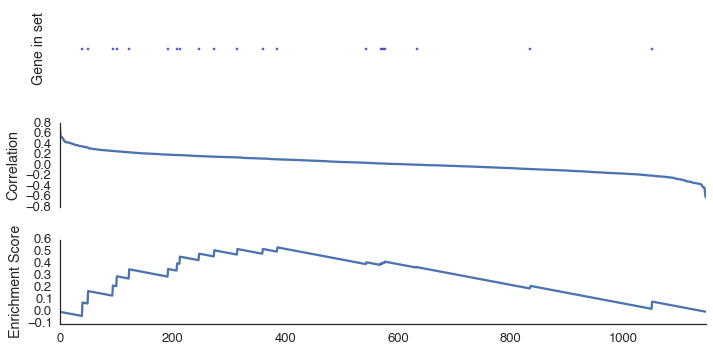

In [40]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(10, 5)) as fig:
    
    ax = fig.add_subplot(3,1,1)
    ax.scatter(genes_in_set.x_loc, genes_in_set.y_loc, s=5, alpha=.6)
    ax.set_xlim(0, len(enrichment_score[go_term]))
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylabel("Gene in set")
    
    ax = fig.add_subplot(3,1,2)
    ax.plot(pc2)
    ax.set_xlim(0, len(enrichment_score[go_term]))
    sns.despine(ax=ax, bottom=True)
    ax.set_xticklabels([])
    ax.set_ylabel("Correlation")
    
    ax = fig.add_subplot(3,1,3)
    ax.plot(enrichment_score[go_term])
    sns.despine(ax=ax)
    ax.set_xlim(0, len(enrichment_score[go_term]))
    ax.set_ylabel("Enrichment Score")

In [66]:
enrichment_score[go_term]['PTEN']

0.1719931758563617

In [92]:
#Compute p-values as in paper, generated z-scores based on only positive or negative distributions

pos_enrichment = largest_enrichment[largest_enrichment >= 0]
neg_enrichment = largest_enrichment[largest_enrichment < 0]

pos_shuffled = shuffled_results[pos_enrichment.index]
neg_shuffled = shuffled_results[neg_enrichment.index]

pos_shuffled = pos_shuffled[pos_shuffled >= 0]
neg_shuffled = neg_shuffled[neg_shuffled < 0]

# pos_z_score = (pos_enrichment - pos_shuffled.mean()) / pos_shuffled.std()
# neg_z_score = (neg_enrichment - neg_shuffled.mean()) / neg_shuffled.std()
# p_values = np.abs(pd.concat([pos_z_score, neg_z_score])).apply(scipy.stats.norm.sf)

pos_p_value = (pos_enrichment > pos_shuffled).sum() / pos_shuffled.count()
neg_p_value = (neg_enrichment < neg_shuffled).sum() / neg_shuffled.count()
p_values = np.abs(pd.concat([pos_p_value, neg_p_value]))



In [69]:
bf_corrected_p_values = p_values * len(p_values)
#bf_corrected_p_values = bf_corrected_p_values[bf_corrected_p_values < .05]
#bf_corrected_p_values = bf_corrected_p_values.sort_values()

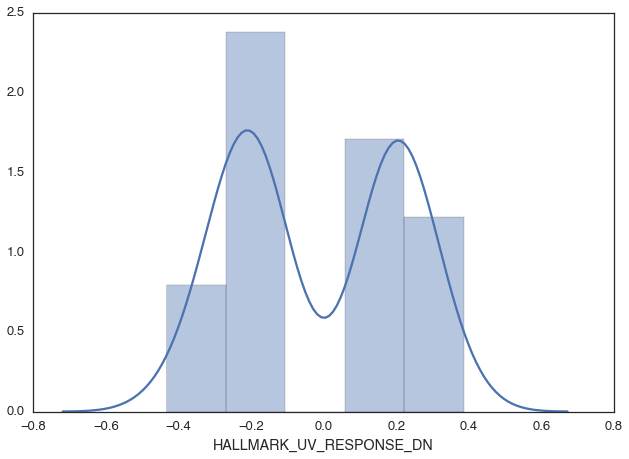

In [50]:
sns.distplot(shuffled_results[go_term])